<a href="https://colab.research.google.com/github/SidorenkArtem/Energy-dataset/blob/master/COMED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files

uploaded = files.upload()

Saving COMED_hourly.csv to COMED_hourly.csv


In [4]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "COMED_hourly.csv" with length 1842915 bytes


In [0]:
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt

series = read_csv('COMED_hourly.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

X = series.values
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
train, test = X[0:train_size], X[test_size:]

history = [x for x in train]
predictions = list()
for i in range(len(test)):
	predictions.append(history[-1])
	history.append(test[i])
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
plt.plot(test[:100], color='blue', label='real')
plt.plot(predictions[:100],color='red', label='predict')
plt.legend()
plt.show()


In [0]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from keras.optimizers import RMSprop

def get_data_from_gen(gen):

    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y


data = pd.read_csv('COMED_hourly.csv', header=0, index_col = 0)

values = data.values
values = values.astype('float32')

n_features = 1
values = values.reshape((len(values), n_features))

scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit(values)

n = scaler.transform(values)

train_size = int(len(n) * 0.67)
test_size = len(n) - train_size
train, test = n[0:train_size,:], n[train_size:len(n),:]

look_back = 10
train_data_gen = TimeseriesGenerator(train, train,
	length=look_back, sampling_rate=1,stride=1,
    batch_size=32)
test_data_gen = TimeseriesGenerator(test, test,
	length=look_back, sampling_rate=1,stride=1,
	batch_size=1)

model = Sequential()
model.add(LSTM(32,activation='relu',dropout=0.2,recurrent_dropout=0.3,
               return_sequences=True, input_shape=(look_back, n_features)))
model.add(LSTM(32, activation='relu', dropout=0.2,
               recurrent_dropout=0.3))
model.add(Dense(1))
model.compile(loss='mae', optimizer=RMSprop(), metrics=['accuracy'])
history = model.fit(train_data_gen, epochs=20,verbose=1, shuffle=False)

trainPredict = model.predict(train_data_gen)
testPredict = model.predict(test_data_gen)

n_trainPredict = scaler.inverse_transform(trainPredict)
n_testPredict = scaler.inverse_transform(testPredict)

trainY = get_data_from_gen(train_data_gen)
testY = get_data_from_gen(test_data_gen)

trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)



In [0]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(trainY[:,0], n_trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], n_testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

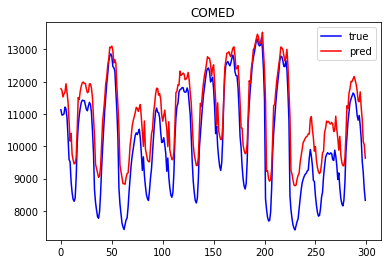

In [88]:
from matplotlib import pyplot as plt
def plot_test():
  temp = testY[10000:10300, 0]  
  temp1 = n_testPredict[10000:10300, 0]
  plt.title('COMED')
  plt.plot(range(len(temp)), temp, 'b',label = 'true')
  plt.plot(range(len(temp1)), temp1, 'r', label = 'pred')
  plt.legend()
  plt.show()
plot_test()

In [0]:
import numpy as np
def pred_next_element(data1, model, look_back, n_features):
  x_input = np.arange(look_back)
  for i in range(look_back):
    x_input[i] = data1[int(len(data1)-len(x_input) + i)]
  x_input = x_input.reshape(1,look_back, n_features)
  pred_num = model.predict(x_input, verbose=1)
  return pred_num
  
print(pred_next_element(testY, model, look_back, n_features))